<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/03a_training_phasenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [17]:
# !pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [18]:
# try:
#     import obspy
#     obspy.read()
# except TypeError:
#     # Needs to restart the runtime once, because obspy only works properly after restart.
#     print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
#     exit()

# Training PhaseNet

This tutorial shows how to train a model with SeisBench, using PhaseNet as an example. This brings together the three main components of SeisBench: data, models and generate.

The tutorial is intended to highlight the basic principles of training models in SeisBench. However, this will not necessarily be best practice for more elaborate experiments. As a reference how to set up larger studies and which augmentations can be used for which models, we refer to the implementation of our pick benchmark at [https://github.com/seisbench/pick-benchmark](https://github.com/seisbench/pick-benchmark).

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [19]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

In [20]:
from config import load_config
cfg = load_config('Kaki-cfg.yml')
print(cfg)

path: inp: /home/ekarkooti/Documents
catalog: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Catalog-get-1403-06-10/kaki_all.out
stream: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/raw-gcf-data
network_details: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Kaki_station-sensor-region-coords.csv
dataset: ./Kaki-Dataset-All_1403-06-12
model: path: ./model
name: PhaseNet_Kaki_1403-06





## Model and data

We create a randomly initialized PhaseNet model using `seisbench.models`. If available, you can move your model onto the GPU for faster training.

In [21]:
model = sbm.PhaseNet(phases="PSN", norm="peak")


# model.cuda();

As training data we use the ETHZ dataset. Note that we set the sampling rate to 100 Hz to ensure that all examples are consistent in terms of sampling rate. We split the data into training, development and test sets according to the splits provided.

In [22]:
from pathlib import Path

data = sbd.WaveformDataset(cfg.path.dataset, sampling_rate=100)
train, dev, test = data.train_dev_test()

2024-09-02 15:39:57,231 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [23]:
l = len(data)
print(l)
data.metadata['split'][0: l-l//4] = 'train'
data.metadata['split'][l-l//4: l-l//8] = 'dev'
data.metadata['split'][l-l//8: ] = 'test'



287


/tmp/ipykernel_18221/3078054660.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.metadata['split'][0: l-l//4] = 'train'
/tmp/ipykernel_18221/3078054660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [24]:
train, dev, test = data.train_dev_test()
print(train, dev, test)

Unnamed dataset - 216 traces Unnamed dataset - 36 traces Unnamed dataset - 35 traces


## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [25]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A normalization, consisting of demeaning and amplitude normalization.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label

In [26]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

Let's visualize a few training examples. Everytime you run the cell below, you'll see a different training example.

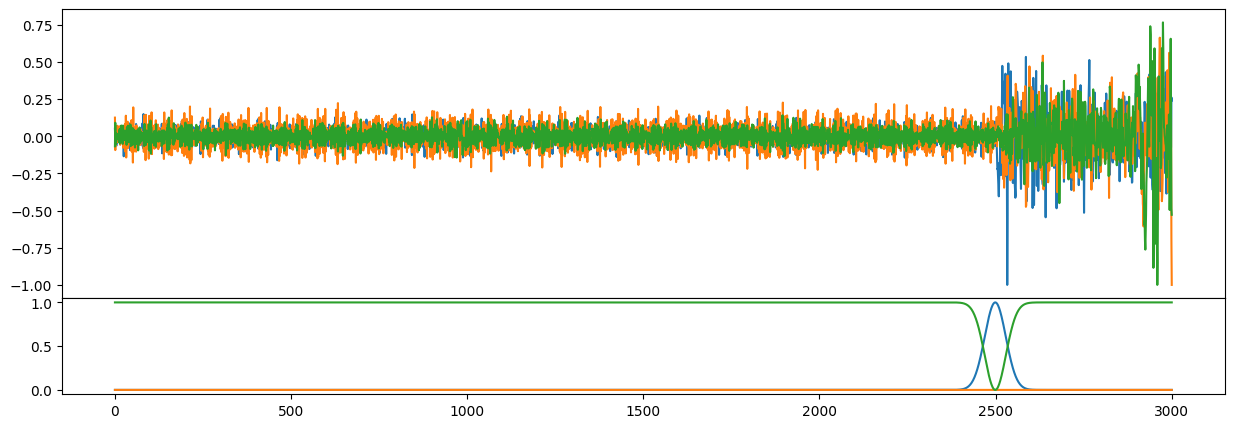

In [27]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 256 samples. This batch size should fit on most hardware.

In [28]:
batch_size = 256 * 2
num_workers = 4 * 2 # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

## Training a model

Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [29]:
learning_rate = 1e-4
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [30]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [31]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 1.297347  [    0/  216]
Test avg loss: 1.265872 

Epoch 2
-------------------------------
loss: 1.293938  [    0/  216]
Test avg loss: 1.267039 

Epoch 3
-------------------------------
loss: 1.289705  [    0/  216]
Test avg loss: 1.268557 

Epoch 4
-------------------------------
loss: 1.285196  [    0/  216]
Test avg loss: 1.268938 

Epoch 5
-------------------------------
loss: 1.282082  [    0/  216]
Test avg loss: 1.268037 



In [34]:
import os
os.mkdir(cfg.path.model.path)

txt = 'The first try of Training a model with Iranian Dataset. PhaseNet architecture was trained with the Kaki dataset. The dataset selected randomly.'
model.save(path=f'{cfg.path.model.path}/{cfg.path.model.name}',
           weights_docstring=txt,
           version_str=None)

## Remarks

As discussed in the data basics tutorial, loading a SeisBench dataset only means loading the metadata into memory. The waveforms are only loaded once they are requested to save memory. By default, waveforms are **not** cached in memory. For training, this means that the data needs to be read from the file in every epoch again. Depending on your hardware, this will take a lot of time. To solve this issue, you can set the `cache` option, when creating the dataset. Then, all you have to do is call `preload_waveforms` and the data will be loaded into memory and automatically cached. For most practical applications, this option is recommended.